# Hackathon team 8

Vamos a inspirarnos del formalismo utilizado en el paper adjunto de la literatura:


Q: Qiskit tiene implementado el HHL de manera directa ??
R: No, Creo que Classiq si, pero pico con la wea


Solución: Implementar el algoritmo nosotros:


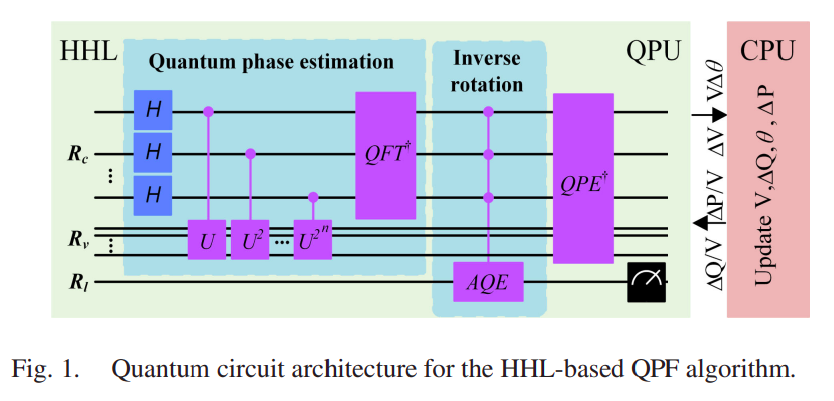

In [24]:
from qiskit.circuit.library import PhaseEstimation, UnitaryGate
from qutip import rand_unitary
from qiskit.circuit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.quantum_info import Operator, Statevector
from qiskit_aer.primitives import Sampler


def HHL_algorithm_original(Unitary : UnitaryGate,
                           num_qubits_register : int,
                           ):


    # step 1) phase estimation primitive
    qpe_circuit = PhaseEstimation(num_evaluation_qubits= num_qubits_register,
                                  unitary= Unitary)
    
    # step 2) Ancilla Quantum Encoding:
    # revisar el Nielsen and Chuang si tiene dudas de esto:
    # paper adjunto tambien
    q_ancilla_reg, q_system_reg = qpe_circuit.qregs
    aqe_reg = QuantumRegister(1)
    cr = ClassicalRegister(1)
    

    # incializamos el circuito cuántico del HHL:
    hhl_qc = QuantumCircuit(q_ancilla_reg, q_system_reg, aqe_reg, cr)
    
    # le añadimos la parte del QPE:
    hhl_qc.compose(qpe_circuit, inplace=True)

    hhl_qc.barrier()

    # añadimos la parte del AQE:
    for i in range(num_qubits_register):
        rot_angle = 2 ** (-( 1 + i))
        hhl_qc.cry(theta= rot_angle,
                   control_qubit= q_ancilla_reg[i],
                   target_qubit= aqe_reg[0])
        
    hhl_qc.barrier()

    
    # añadimos la inversa del QPE:
    hhl_qc.compose(qpe_circuit.inverse(), inplace=True)

    hhl_qc.barrier()
    #medimos:
    hhl_qc.measure(aqe_reg, cr)

    with hhl_qc.if_test((cr, 1)):
        print(1)

        sampler = Sampler()

        print( len(q_system_reg))
        meas = ClassicalRegister(len(q_system_reg))
        hhl_qc.add_register(meas)

        hhl_qc.measure(q_system_reg, meas)

        draw_output = hhl_qc.copy()

        result = sampler.run(circuits= hhl_qc, shots= 2 ** 12)
        return result, draw_output
    
    


prueba del algoritmo:

In [25]:
u_try = rand_unitary(dimensions= 8).full()
u_op = Operator(u_try).to_instruction()


job_result, hhl_cirq = HHL_algorithm_original(Unitary= u_op,
                                     num_qubits_register= 5)




#hhl_circuit.draw('mpl')



1
3


/tmp/ipykernel_7259/2067517894.py:5: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  job_result, hhl_cirq = HHL_algorithm_original(Unitary= u_op,


In [28]:
import numpy as np

print(job_result.result().quasi_dists[0])

prob_count = job_result.result().quasi_dists[0]



hhl_cirq.draw('mpl')

def prob_dict_to_state(prob_dict):
    """Convierte {index: prob} en un vector de estado (amplitudes reales y positivas)."""
    dim = 2**int(np.ceil(np.log2(max(prob_dict.keys())+1)))
    state = np.zeros(dim)
    for k, p in prob_dict.items():
        state[k] = np.sqrt(p)
    # normalizar por seguridad
    state = state / np.linalg.norm(state)
    return state


post_processed_state = prob_dict_to_state(prob_count)

print(post_processed_state)

Statevector(post_processed_state).draw('latex')

{9: 0.0009765625, 13: 0.00537109375, 7: 0.00244140625, 3: 0.0009765625, 5: 0.0048828125, 1: 0.107421875, 15: 0.001220703125, 0: 0.876708984375}
[0.93632739 0.32775277 0.         0.03125    0.         0.06987712
 0.         0.04941059 0.         0.03125    0.         0.
 0.         0.07328775 0.         0.03493856]


<IPython.core.display.Latex object>

en su maximo explendor:

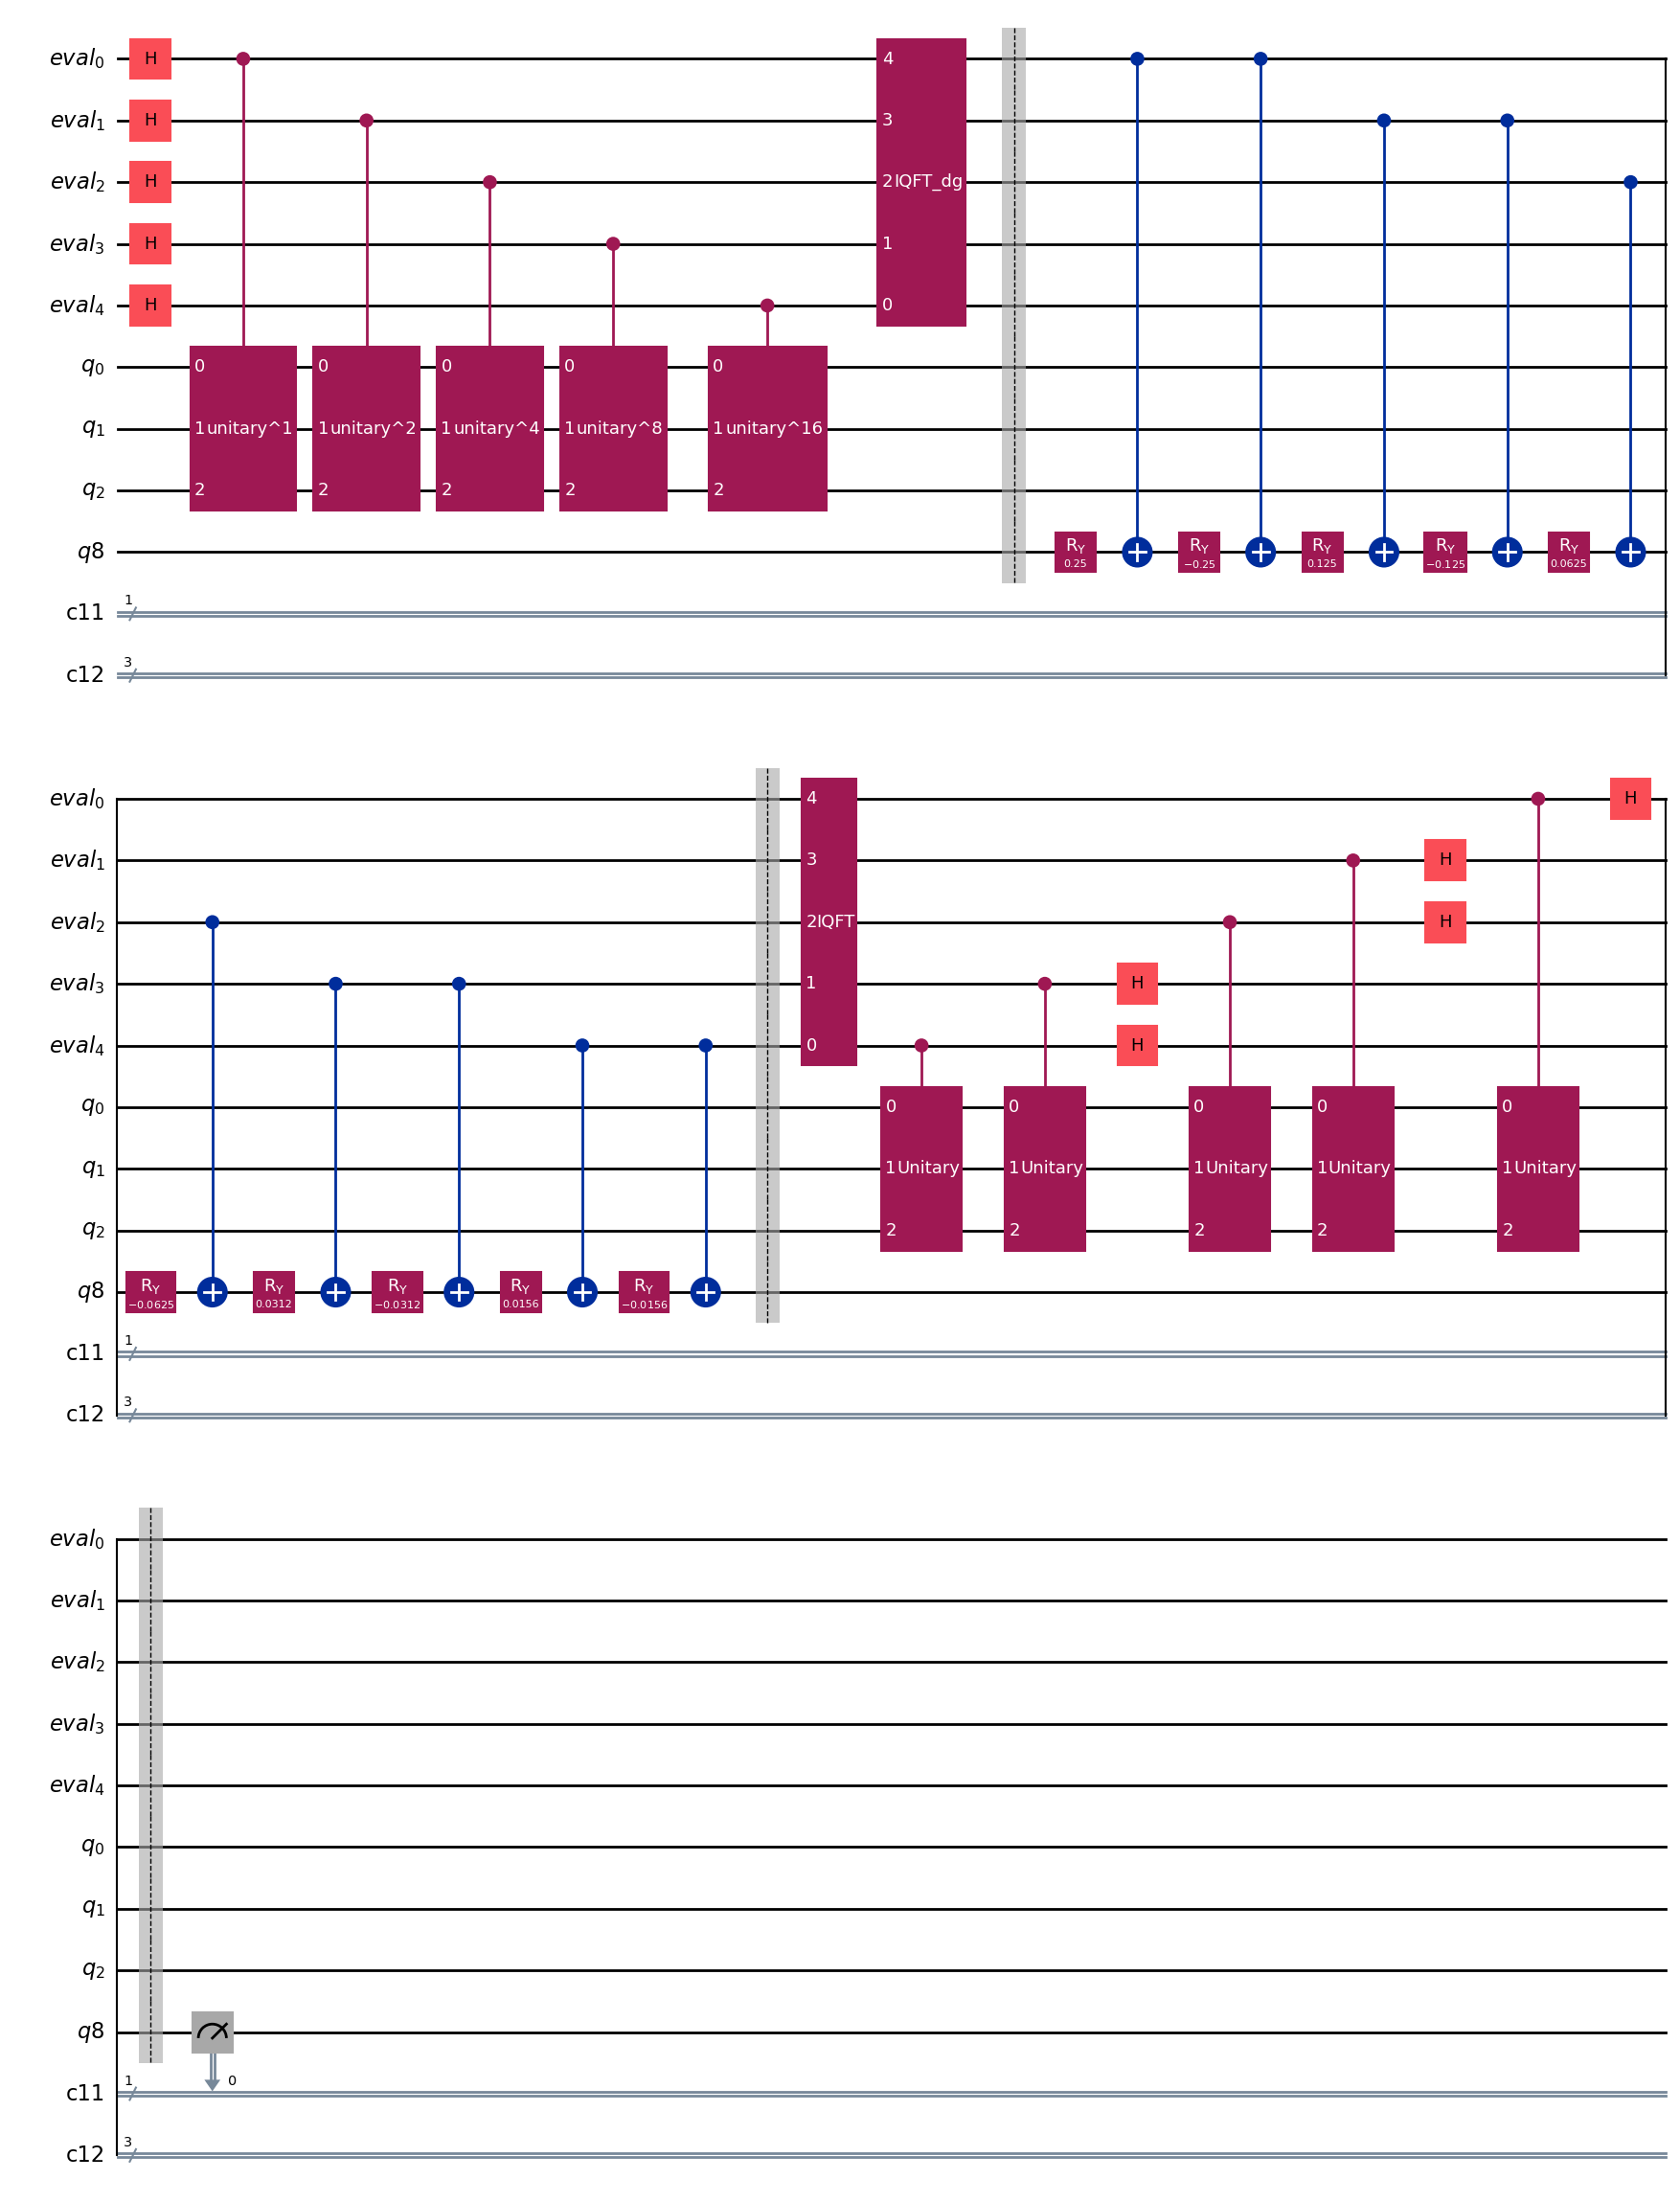

In [30]:
hhl_cirq.decompose().draw('mpl')



Encoding of the Fast Decoupled QPF Formulation:

$$
\ket{V^{-1} \Delta P } = B' \ket{V \Delta \Theta} \\
\ket{V^{-1} \Delta Q} = B'' \ket{\Delta V}
$$

$$
\to \ket{}
$$


pregunta para los Hackers: que información tiene que codificar la matriz unitaria U ?

hay que implementar este algoritmo, es muy straightforward (pero no facil):

recordar que hay que tener en claro como se plantea las matrices $S, Y, B' y B''$ respectivamente. Ya con eso podemos hacer las cosas bien (hopefully...)




## Modified Algorithm



In [29]:
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Sampler
from qiskit_machine_learning.gradients import ParamShiftSamplerGradient


def novel_QPF_algorithm(bin_DeltaQ : np.array,
                        bin_DeltaP : np.array,
                        treshold : float,
                        Optimization_parameters : np.array
                        ):
    
    
    #initial 

    # Convertir los arrays a tipo float antes de la normalización
    # La división /= resultará en floats, lo que evitará el error
    bin_DeltaP = bin_DeltaP.astype(float)
    bin_DeltaQ = bin_DeltaQ.astype(float)

    bin_DeltaP /= np.linalg.norm(bin_DeltaP)
    bin_DeltaQ /= np.linalg.norm(bin_DeltaQ)

    u_try = rand_unitary(dimensions= 4).full()
    u_op = Operator(u_try).to_instruction()

    Bp, Bpp = u_op, u_op

    hhl_qc_1 = HHL_algorithm_original(Bp, num_qubits_register= 5)
    hhl_qc2 = HHL_algorithm_original(Bpp, num_qubits_register= 5)




    qc_DeltaV_est = hhl_qc_1.copy_empty_like()
    qc_V_DeltaTheta_est = hhl_qc2.copy_empty_like()

    ket_Vm1_DeltaQ, ket_Vm1_DeltaP = Statevector(bin_DeltaQ), Statevector(bin_DeltaP)

    q_inits1 = qc_DeltaV_est.qregs[1]
    q_inits2 = qc_V_DeltaTheta_est.qregs[1]


    qc_V_DeltaTheta_est.initialize(ket_Vm1_DeltaP, qubits= q_inits2)
    qc_DeltaV_est.initialize(ket_Vm1_DeltaQ, qubits= q_inits1)

    qc_V_DeltaTheta_est.compose(hhl_qc2, inplace=True)
    qc_DeltaV_est.compose(hhl_qc_1, inplace=True)

    def ansatz(params : np.array, num_qubits_sys : int):
        qc = QuantumCircuit(num_qubits_sys, name= 'ansatz')

        params = ParameterVector("θ", length=num_qubits_sys)
        #esto es solo una prueba jejej
        for i in range(num_qubits_sys):
            qc.rx(params[i], i)

        return qc

    #cambiar esto despues...
    ansatz_1, ansatz_2 = ansatz(Optimization_parameters, len(q_inits1)), ansatz(Optimization_parameters, len(q_inits2))

    qc_DeltaV_est.compose(ansatz_1, inplace=True, qubits= q_inits1)
    qc_V_DeltaTheta_est.compose(ansatz_2, inplace=True, qubits= q_inits2)

    sampler = Sampler()

    result = sampler.run(circuits= [qc_DeltaV_est, qc_V_DeltaTheta_est],
                         parameter_values= [Optimization_parameters, Optimization_parameters],
                         shots= 1)
    
    print(result.result())

    return qc_DeltaV_est, qc_V_DeltaTheta_est

    



qc1, qc2 = novel_QPF_algorithm(bin_DeltaQ= np.array([0,1,0,1]),
                               bin_DeltaP= np.array([1,0,1,0]),
                               treshold= 0.5,
                               Optimization_parameters = np.random.random(2))


qc1.draw('mpl')
    




1
2


/tmp/ipykernel_7259/3953388226.py:30: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  hhl_qc_1 = HHL_algorithm_original(Bp, num_qubits_register= 5)


1
2


/tmp/ipykernel_7259/3953388226.py:31: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  hhl_qc2 = HHL_algorithm_original(Bpp, num_qubits_register= 5)


AttributeError: 'tuple' object has no attribute 'copy_empty_like'

In [ ]:
def QPF_algorithm_original(Phase,
                           Voltage,
                           Bp, Bpp, P, Q, xi, max_num_iter = 100):
    
    # initialize Quantum Circuit:

    #first iteration:
    #do input B' & B'' -> HHL

    #completar esto codigo aquí:

    #nota importar y hacer los samples con Qiskit Aer
    # debido a que con Qiskit Aer se pueden correr las simulaciones
    # en GPU del qBraid y tener mas data.

    for _ in range(max_num_iter):
        pass
        
    


## Argumentation:

Why we are doing this:

Smart monitoring of Power Flow in topological grids is a modern issue for blablabla...

ahora mismo los modelos no son solucionados de manera directa, si no que se hacen modelos predictivos en base al historial de las poblaciones[poner/buscar ref]. Esto supone una desventaja frente a situaciones nunca antes vistas, como el hecho de que cada verano hay mas Aires acondicionados, nuevas fuentes energeticas y demandas distintas debido a procesos randoms[poner ref de esto].

El correcto manejo y reacción de la grid energética permite una eficiencia en el manejo, evitando asi desastres en la civilizacion moderna, como apagones (y sus consecuencias, como problemas de la gente electrodependiente, perecimiento de alimentos de los refrigeradores, daño de electrodomésticos, etc...) La correcta distribución de la grilla ayuda enormemente a las problematicas SDG de ciudades sostenibles y Acción por el Cambio Climático. Por ultimo y no menos importante, este problema es de total relevancia para las industrias de transporte, metalurgica, estatales y privadas de suministración de electricidad, etc.

Este algoritmo tambien permite cambiar la formulación, y cualquier problema que se pueda plantear (de manera inteligente) como análogo a problema de Corriente y voltaje se ganará el golaso. Esto esta hecho en [poner ref]


La razón de la que se hace de forma predictiva y no en tiempo real, es debido a la complejidad (no lineal) y rapido escalado de complejidad algorítmica en sistemas de N nodos (está en el inicio del paper que es de orden $ ~ \mathcal{O}(N)$ ), demandando un gran poder de computo considerando que en una ciudad el orden de nodo es de [completar aquí] y tiempo de resolución de ello.

Proponemos linealizar el problema y utilizar la aproximación de Fast Decoupled Load Flow para atacar este problema y hacer estimaciones de la red topologica de la grilla de manera eficiente.

Por otra parte, el paper propone utilizar el algoritmo HHL, que debidoa que está estudiado de manera analítica, se obtiene una ventaja exponencial con respecto a los metodos clasicos de resolución de sistema de ecuaciones diferenciales: $ \hat{ \mathcal{O} } (N \sqrt{\kappa}) \to \text{poly}(\log N, \kappa) $

Este speedup quantico hará posible la realización de la estimación de la grilla en una escala de tiempo que permitirá la reacción de las centrales de control y haciendo que todo el mundo esté feliz.

Ademas, proponemos modificaciones del algoritmo con el objetivo de poder correr los algoritmos en las eras NISQ, early Fault Tolerant y Fault Tolerant, utilizando modificaciones variacionales, Iterative QPE y el algoritmo original, respectivamente.

Este trabajo será propuesto en la Hackathon y nos ayudará a ser unos gatitos con modales. Espero les guste este trabajo ;)


diganme si todos estan de acuerdos con estas ideas cracks.


In [2]:
import numpy as np

# ---------------------------------------------------
# 1. Definir datos del sistema
# ---------------------------------------------------

n = 5   # número de buses

# Tipo de bus: 0=Slack, 1=PQ, 2=PV
# Según figura del paper: 1–3 PQ, 4 PV, 5 Slack
bus_type = [1, 1, 1, 2, 0]  

# Potencias especificadas (P+jQ)
S_spec = np.array([
    -0.55 - 0.20j,   # Bus 1 (PQ)
    -0.55 - 0.18j,   # Bus 2 (PQ)
    -0.95 - 0.10j,   # Bus 3 (PQ)
     0.20 + 0.20j,   # Bus 4 (PV)
     0.00 + 0.00j    # Bus 5 (Slack)
], dtype=complex)

# Voltajes iniciales
V = np.array([
    1.0*np.exp(1j*0),   # Bus 1
    1.0*np.exp(1j*0),   # Bus 2
    1.0*np.exp(1j*0),   # Bus 3
    1.0*np.exp(1j*0),   # Bus 4
    1.002*np.exp(1j*0)  # Slack
], dtype=complex)

# Matriz de admitancia Ybus (ejemplo toy; ¡reemplazar con la real del paper!)
Ybus = np.array([
    [10-30j, -5+15j, -5+15j,  0,       0     ],
    [-5+15j, 10-30j,  0,     -5+15j,   0     ],
    [-5+15j,  0,     10-30j, -5+15j,   0     ],
    [0,     -5+15j, -5+15j,  15-45j, -10+30j],
    [0,      0,      0,     -10+30j,  10-30j]
], dtype=complex)

# ---------------------------------------------------
# 2. Funciones auxiliares
# ---------------------------------------------------

def power_calc(V, Ybus):
    """Calcula potencias inyectadas en cada bus."""
    I = Ybus @ V
    S = V * np.conj(I)
    return S

def build_jacobian(V, Ybus, bus_type):
    """Construye Jacobiano reducido (NR)."""
    n = len(V)
    G = Ybus.real
    B = Ybus.imag
    Vm = np.abs(V)
    Va = np.angle(V)

    P = np.zeros(n)
    Q = np.zeros(n)

    for i in range(n):
        for k in range(n):
            P[i] += Vm[i]*Vm[k]*(G[i,k]*np.cos(Va[i]-Va[k]) + B[i,k]*np.sin(Va[i]-Va[k]))
            Q[i] += Vm[i]*Vm[k]*(G[i,k]*np.sin(Va[i]-Va[k]) - B[i,k]*np.cos(Va[i]-Va[k]))

    # Variables: theta en PV+PQ, V solo en PQ
    ang_vars = [i for i in range(n) if bus_type[i] in [1,2] and bus_type[i]!=0]
    mag_vars = [i for i in range(n) if bus_type[i] == 1]

    J11 = np.zeros((len(ang_vars), len(ang_vars)))
    J12 = np.zeros((len(ang_vars), len(mag_vars)))
    J21 = np.zeros((len(mag_vars), len(ang_vars)))
    J22 = np.zeros((len(mag_vars), len(mag_vars)))

    # Fill J
    for ii,i in enumerate(ang_vars):
        for jj,j in enumerate(ang_vars):
            if i == j:
                J11[ii,jj] = -Q[i] - Vm[i]**2 * B[i,i]
            else:
                J11[ii,jj] = Vm[i]*Vm[j]*(G[i,j]*np.sin(Va[i]-Va[j]) - B[i,j]*np.cos(Va[i]-Va[j]))

        for jj,j in enumerate(mag_vars):
            if i == j:
                J12[ii,jj] = P[i]/Vm[i] + Vm[i]*G[i,i]
            else:
                J12[ii,jj] = Vm[i]*(G[i,j]*np.cos(Va[i]-Va[j]) + B[i,j]*np.sin(Va[i]-Va[j]))*Vm[j]

    for ii,i in enumerate(mag_vars):
        for jj,j in enumerate(ang_vars):
            if i == j:
                J21[ii,jj] = P[i] - Vm[i]**2 * G[i,i]
            else:
                J21[ii,jj] = -Vm[i]*Vm[j]*(G[i,j]*np.cos(Va[i]-Va[j]) + B[i,j]*np.sin(Va[i]-Va[j]))

        for jj,j in enumerate(mag_vars):
            if i == j:
                J22[ii,jj] = Q[i]/Vm[i] - Vm[i]*B[i,i]
            else:
                J22[ii,jj] = Vm[i]*(G[i,j]*np.sin(Va[i]-Va[j]) - B[i,j]*np.cos(Va[i]-Va[j]))*Vm[j]

    # Armar Jacobiano final
    J = np.block([[J11, J12],
                  [J21, J22]])
    return J, ang_vars, mag_vars

# ---------------------------------------------------
# 3. Iteración Newton-Raphson
# ---------------------------------------------------

tol = 1e-6
max_iter = 20

for it in range(max_iter):
    S_calc = power_calc(V, Ybus)
    mis = S_spec - S_calc

    ang_vars = [i for i in range(n) if bus_type[i] in [1,2]]
    mag_vars = [i for i in range(n) if bus_type[i] == 1]

    dP = mis[ang_vars].real
    dQ = mis[mag_vars].imag
    mismatch = np.concatenate([dP, dQ])

    if np.max(np.abs(mismatch)) < tol:
        print(f"Convergió en {it} iteraciones")
        break

    J, ang_vars, mag_vars = build_jacobian(V, Ybus, bus_type)
    dx = np.linalg.solve(J, mismatch)

    dtheta = dx[:len(ang_vars)]
    dV = dx[len(ang_vars):]

    # actualizar variables
    for k,i in enumerate(ang_vars):
        V[i] *= np.exp(1j*dtheta[k])   # actualizar ángulo

    for k,i in enumerate(mag_vars):
        V[i] *= (1 + dV[k]/abs(V[i]))  # actualizar magnitud

# ---------------------------------------------------
# 4. Resultados
# ---------------------------------------------------
for i in range(n):
    print(f"Bus {i+1}: V = {abs(V[i]):.4f} ∠ {np.degrees(np.angle(V[i])):.2f}°")


Convergió en 6 iteraciones
Bus 1: V = 0.9492 ∠ 1.56°
Bus 2: V = 0.9625 ∠ 2.86°
Bus 3: V = 0.9605 ∠ 2.08°
Bus 4: V = 1.0000 ∠ 5.85°
Bus 5: V = 1.0020 ∠ 0.00°


# Try to implement the novel HHL algorithm improved:

